In [119]:
import pandas as pd
from provisioning_model.functions.exploratory_analysis import create_scatter_plots_grid

In [120]:
time_periods = ['2008', '2012', '2016', '2020']
foundational_df_no_transformations = pd.read_csv('./output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('./output/foundational_transformed.csv')

## Hypothesis

The higher the share of employment/labor in the Foundational sector of the economy, the higher the chance that related needs could be met at a low level of energy use

## Key assumptions and parameters (TBD)

## Preliminary checks

Find and remove outliers

In [121]:
create_scatter_plots_grid(foundational_df_no_transformations, 'TIME_PERIOD', ['overlooked', 'material', 'providential', 'other'], time_periods)

Based on visual inspection, LU 2008, AL 2016, AL 2020, TR 2016, IS 2008, MT 2012 are outliers

In [122]:
outliers_to_remove = [{'geo': 'LU', 'TIME_PERIOD': 2008}, {'geo': 'AL', 'TIME_PERIOD': 2016}, {'geo': 'AL', 'TIME_PERIOD': 2020}, {'geo': 'TR', 'TIME_PERIOD': 2016}, {'geo': 'IS', 'TIME_PERIOD': 2008}, {'geo': 'MT', 'TIME_PERIOD': 2012}]
foundational_df_transformed_no_outliers = foundational_df_transformed.copy()
for outlier in outliers_to_remove:
    foundational_df_transformed_no_outliers = foundational_df_transformed_no_outliers[~((foundational_df_transformed_no_outliers['geo'] == outlier['geo']) & (foundational_df_transformed_no_outliers['TIME_PERIOD'] == outlier['TIME_PERIOD']))]
print('Number of rows in foundational_df_transformed: {}'.format(len(foundational_df_transformed)))
print('Number of rows in foundational_df_transformed_no_outliers: {}'.format(len(foundational_df_transformed_no_outliers)))

Number of rows in foundational_df_transformed: 131
Number of rows in foundational_df_transformed_no_outliers: 125


## Reproducing JV analysis with new data

Conduct a Pooled OLS regression with the following variables:
 - Dependent variable: HALE
 - Independent variables: Energy, Material, Government Effectiveness, Gini, Other

Conduct the same regression on the dataset with and without outliers

In [123]:
import statsmodels.api as sm
import numpy as np

In [124]:
regression_df = foundational_df_transformed.copy()
regression_df_no_outliers = foundational_df_transformed_no_outliers.copy()
# regression_df['energy_material'] = regression_df['energy'] * regression_df['material']

In [125]:
def pooled_ols_reg(regression_df, y_variable, x_variables):
    # remove inf and nan
    pooled_x = regression_df[x_variables]
    pooled_x = pooled_x.replace([np.inf, -np.inf], np.nan)
    pooled_x = pooled_x.dropna()
    # only keep same geo and TIME_PERIOD in pooled_y as in pooled_x
    pooled_y = regression_df[y_variable]
    pooled_y = pooled_y[pooled_y.index.isin(pooled_x.index)]
    pooled_y = pooled_y.dropna()
    # keep only same geo and TIME_PERIOD in pooled_x as in pooled_y
    pooled_x = pooled_x[pooled_x.index.isin(pooled_y.index)]
    pooled_x = sm.add_constant(pooled_x)
    pooled_olsr_model = sm.OLS(endog=pooled_y, exog=pooled_x)
    pooled_olsr_model_results = pooled_olsr_model.fit()
    print(pooled_olsr_model_results.summary())
    return pooled_olsr_model_results

First use healthy life expectancy (hale) as the dependent variable

In [126]:
pooled_ols_reg(regression_df, 'hale', ['energy', 'material', 'goveffectiveness', 'gini' ,'other'])

                            OLS Regression Results                            
Dep. Variable:                   hale   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     22.80
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           3.31e-15
Time:                        23:20:06   Log-Likelihood:                -110.54
No. Observations:                 106   AIC:                             233.1
Df Residuals:                     100   BIC:                             249.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0491      0.070  

In [127]:
hale_results = pooled_ols_reg(regression_df_no_outliers, 'hale', ['energy', 'material', 'goveffectiveness', 'gini' ,'other'])

                            OLS Regression Results                            
Dep. Variable:                   hale   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     22.93
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           5.00e-15
Time:                        23:20:06   Log-Likelihood:                -105.36
No. Observations:                 101   AIC:                             222.7
Df Residuals:                      95   BIC:                             238.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0370      0.072  

In [128]:
print('Mean value of residual errors='+str(hale_results.resid.mean()))

Mean value of residual errors=-2.3853306568679107e-16


Mean value of residual errors is close to zero, which is expected.

/var/folders/6l/9wnlb_cx2h382r0y3jq99h5h0000gn/T/ipykernel_22550/3272153788.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



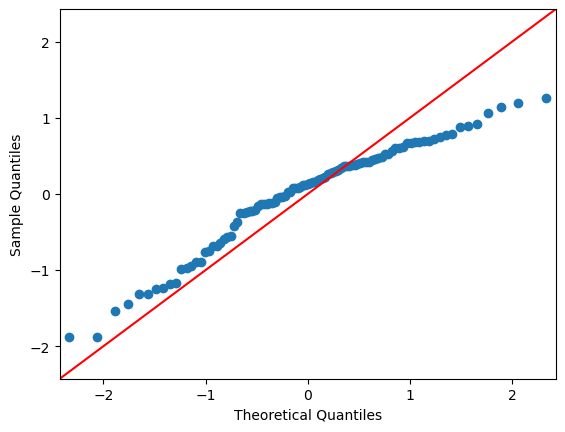

In [129]:
qqplt = sm.qqplot(data=hale_results.resid, line='45')
qqplt.show()

Result for the dataset without outliers: R-squared = 0.523 (with outliers 0.509)
Material has a positive coefficient 0.53 with p-value >0.000 (for every unit increase in material share, HALE increases by 0.53 years)
Other has a negative coefficient -0.226 with p-value 0.014 (for every unit increase in other share, HALE decreases by 0.226 years)

Next use education as the dependent variable

In [ ]:
pooled_ols_reg(regression_df_no_outliers, 'education', ['energy',  'goveffectiveness','providential'])

Result for the dataset without outliers: R-squared = 0.347. 
Somewhat low, needs more work. Could be due to a lower sample size (46 observations).
Might be early to interpret the results.

Next: conduct further checks for heteroskedasticity, etc.

## Regression by sector (Later)
 - Use sectoral energy input (per cap? share?), sectoral labor share and sector-related need satisfaction variable

## Regression by region (Later)
 - Use total regional energy input (per cap? share?), total regional labor share and total regional need satisfaction variable

**Note**: We're not doing a fourth set of 
regressions by region + input due to data availability. Maybe in future research